In the previous tutorial, you learned how to use install the analysis framework and use it to calculate a differential sensitivity to the diffuse flux of cosmogenic neutrinos. In this tutorial, we will calculate a sensitivity to a population of transient point sources. In contrast to the diffuse tutorial we will be using full angular and time information, reducing background levels signficantly. We will again use the Fictive detector.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from functools import partial
from gen2_analysis import factory, diffuse, surface_veto, pointsource, grb, multillh, plotting
import warnings
warnings.filterwarnings("ignore") # turn off warnings

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
aeffs = factory.get('Fictive-Optical')

A targeted point source search is modeled as a counting experiment in bins of opening angle around a known source location and energy proxy (MuEx-ish). To see what this looks like, we can construct the expected counts these bins from a steady source with a flux of E^2 Phi = 10^-12 TeV cm^-2 s^-1 located at a declination of 5 degrees:

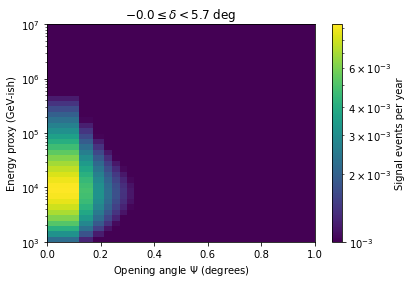

In [4]:
from matplotlib.colors import LogNorm
track_aeff = aeffs['unshadowed_tracks'][0]
# find the zenith band corresponding to declination 5 degrees
zi = track_aeff.get_bin_edges('true_zenith_band').searchsorted(-np.sin(np.radians(5)))-1
ax = plt.gca()
plt.pcolor(
    np.degrees(track_aeff.get_bin_edges('reco_psi')[:-1]),
    track_aeff.get_bin_edges('reco_energy'),
    pointsource.SteadyPointSource(track_aeff, livetime=1, zenith_bin=zi).expectations(ps_gamma=-2),
    norm=LogNorm(vmin=1e-3))
ax.semilogy()
ax.set_ylim(1e3,1e7)
ax.set_xlim(0,1)
ax.set_xlabel('Opening angle $\Psi$ (degrees)')
ax.set_ylabel('Energy proxy (GeV-ish)')
dec = np.degrees(np.arcsin(-track_aeff.get_bin_edges('true_zenith_band')))
ax.set_title('${:.1f} \leq \delta < {:.1f}$ deg'.format(*dec[zi+1:zi-1:-1]))
plt.colorbar().set_label('Signal events per year')

Of course there is more than signal to worry about. In the Northern sky the background is dominated by atmospheric neutrinos, while in the Southern sky you quickly run into penetrating muons:

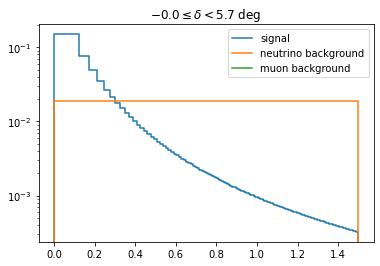

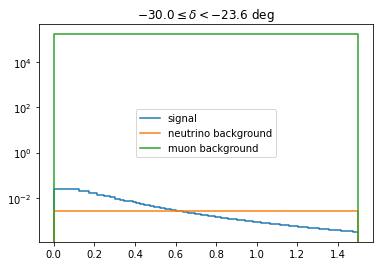

In [5]:
muon_aeff = aeffs['unshadowed_tracks'][1]

for dec in 5, -25:
    zi = track_aeff.get_bin_edges('true_zenith_band').searchsorted(-np.sin(np.radians(dec)))-1

    plt.figure()
    ax = plt.gca()
    dec = np.degrees(np.arcsin(-track_aeff.get_bin_edges('true_zenith_band')))
    ax.set_title('${:.1f} \leq \delta < {:.1f}$ deg'.format(*dec[zi+1:zi-1:-1]))
    exes = [
        ('signal', pointsource.SteadyPointSource(track_aeff, livetime=1, zenith_bin=zi).expectations(ps_gamma=-2).sum(axis=0)),
        ('neutrino background', diffuse.AtmosphericNu.conventional(track_aeff, livetime=1).point_source_background(zenith_index=zi).expectations.sum(axis=0)),
        ('muon background', surface_veto.MuonBundleBackground(muon_aeff, livetime=1).point_source_background(zenith_index=zi, psi_bins=track_aeff.get_bin_edges('reco_psi')[:-1]).expectations.sum(axis=0)),
    ]
    for label, ex in exes:
        plt.plot(*plotting.stepped_path(
            np.degrees(track_aeff.get_bin_edges('reco_psi')[:-1]),
            ex),
            label=label
        )
    plt.legend()
    plt.semilogy(nonpositive='clip')

A stacking search is a weighted sum of these over all zenith bands, e.g. 10 sources from 0 to 5 degrees declination, 5 from 5 to 15, etc. The background expectations are scaled by the same factor, and all expectations multiplied by the assumed livetime. A stacked transient search is similar, though we work directly with fluences instead of integrating fluxes over an assumed livetime. To model the varying observation time, we can either assume that we observe for, say, exactly T_90 for every source, and integrate the backgrounds for that duration, or assume a distribution of integration times, and scale the signal event counts to account for the fraction of the total fluence expected during each observation window. For simplicity in this example we choose the first option.

First, we define a factory function to create predictions for each of our effective areas:

In [7]:
def make_components(aeffs, z=2, t90=45.1, Eiso=53.5, nsources=300):
    aeff, muon_aeff = aeffs
    energy_threshold = np.inf
    atmo = diffuse.AtmosphericNu.conventional(aeff, 1., hard_veto_threshold=energy_threshold)
    atmo.uncertainty = 0.1
    prompt = diffuse.AtmosphericNu.prompt(aeff, 1., hard_veto_threshold=energy_threshold)
    prompt.min = 0.5
    prompt.max = 3
    astro = diffuse.DiffuseAstro(aeff, 1.)
    astro.seed = 2
    zi = slice(None) # use all zenith bands
    livetime = t90*nsources # single burst duration
    atmo_bkg = atmo.point_source_background(zenith_index=zi, livetime=livetime)
    prompt_bkg = prompt.point_source_background(zenith_index=zi, livetime=livetime)
    astro_bkg = astro.point_source_background(zenith_index=zi, livetime=livetime)

    z = z*np.ones(nsources)
    # assume all sources have the same luminosity and are at the same redshift
    ps = grb.GRBPopulation(aeff,
                           z*np.ones(nsources),
                           Eiso=10**(Eiso*np.ones(nsources)),
                          )
    
    components = dict(atmo=atmo_bkg, prompt=prompt_bkg, astro=astro_bkg, ps=ps)
    if muon_aeff is not None:
        components['muon'] = surface_veto.MuonBundleBackground(muon_aeff, 1).point_source_background(zenith_index=zi, psi_bins=aeff.get_bin_edges('reco_psi')[:-1], livetime=livetime)
    return components

# Assume a 15-year exposure. Essentially, assume you see copies of the same 300 bursts every year.
bundle = factory.component_bundle({'Fictive-Optical': 15}, partial(make_components, z=2, t90=45.1, Eiso=53.5))

Using this, we fit for the median model discovery factor:

In [8]:
components = bundle.get_components()
ps = components.pop('ps')
components['gamma'] =  multillh.NuisanceParam(-2.3, 0.5, min=-2.7, max=-1.7)
components['ps_gamma'] =  multillh.NuisanceParam(-2, 0.5, min=-2.7, max=-1.7)
kwargs = {k:v.seed for k,v in components.items()}
mdf, ns, nb = pointsource.discovery_potential(ps, components, **kwargs)
mdf

INFO:root:baseline: 1.2e+03 actual 8.3 ns: 3.4 nb: 9.3e+05 ts: 25


8.30637168696029

This means that in 50% of 15-year exposures of the fictive detector, we would expect to see a 5 sigma excess over isotropic background by collecting events for 45 seconds around the time of the presumed 300 bursts per year. To adapt this to another model, you would need to change the way the total fluence is calculated for each zenith band. This includes:
- the overall normalization: in this case it is sort of arbitrary, but it makes sense to tie it to a fixed fraction of the observed diffuse flux
- the energy dependence of the differential fluence from each transient
- the number of transients per year
- the t_90 of each transient

Have a look at the implementation of grb.GRBPopulation for an example. Note that fluences passed to the pointsource.PointSource constructor are per particle type rather than per neutrino family, i.e. 1/6 of the all-flavor flux for a 1:1:1 flavor ratio rather than 1/3 as in the usual IceCube convention.